<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Only-image" data-toc-modified-id="Only-image-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Only image</a></span><ul class="toc-item"><li><span><a href="#Train-test-vit" data-toc-modified-id="Train-test-vit-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train test vit</a></span></li><li><span><a href="#Train-test-resnet50" data-toc-modified-id="Train-test-resnet50-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train test resnet50</a></span></li><li><span><a href="#Effnetb0-(noclip)" data-toc-modified-id="Effnetb0-(noclip)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Effnetb0 (noclip)</a></span></li></ul></li><li><span><a href="#Only-text" data-toc-modified-id="Only-text-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Only text</a></span><ul class="toc-item"><li><span><a href="#Traduction-indonesian-english" data-toc-modified-id="Traduction-indonesian-english-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Traduction indonesian english</a></span></li><li><span><a href="#Split" data-toc-modified-id="Split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split</a></span></li><li><span><a href="#Split-no-translation" data-toc-modified-id="Split-no-translation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split no translation</a></span></li></ul></li><li><span><a href="#Multimodal-training" data-toc-modified-id="Multimodal-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multimodal training</a></span><ul class="toc-item"><li><span><a href="#Testing-zero-shot" data-toc-modified-id="Testing-zero-shot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Testing zero shot</a></span><ul class="toc-item"><li><span><a href="#Translated-titles" data-toc-modified-id="Translated-titles-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Translated titles</a></span></li><li><span><a href="#No-translation" data-toc-modified-id="No-translation-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>No translation</a></span></li></ul></li><li><span><a href="#Fine-tuning-clip" data-toc-modified-id="Fine-tuning-clip-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fine tuning clip</a></span><ul class="toc-item"><li><span><a href="#Zero-shot-without-fine-tuning-on-split" data-toc-modified-id="Zero-shot-without-fine-tuning-on-split-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Zero shot without fine tuning on split</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import torch
import clip
from PIL import Image

## Only image

In [2]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

### Train test vit

In [1]:
from imports import *
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from clip_.train_image import *
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
# creating dataloaders
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'
bs = 64

tr_dl = create_dl(train_df, small_images_dir_train, batch_size=bs)
tr_test_dl = create_dl(train_df, small_images_dir_val, shuffle=False, batch_size=bs)
val_dl = create_dl(val_df, small_images_dir_val, shuffle=False, batch_size=bs)
#full_dl = create_dl(df, small_images_dir, shuffle=False)

In [4]:
class CLIPImg(torch.nn.Module) :
    def __init__(self, model_name="ViT-B/32", device='cuda') :
        super().__init__()
        self.model = clip.load(model_name, device=device, jit=False)[0]
    def forward(self, imgs) :
        return self.model.encode_image(imgs)

In [5]:
model = CLIPImg()
train_tfms, val_tfms = get_tfms(crop=224)

In [6]:
centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
torch.save(centers, 'data/clip/centers_im_0.3_vit.pth')

In [7]:
centers = torch.load('data/clip/centers_im_0.3_vit.pth')

In [8]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers, half=True).to(device)

Using center as wieghts


In [9]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=8)

for n, _ in model.named_parameters() :
    print(n)

In [10]:
mnp = list(model.named_parameters())

start = ['model.visual.class_embedding', 'model.visual.positional_embedding', 'model.visual.conv1.weight',
        'model.visual.ln_pre.weight', 'model.visual.ln_pre.bias']
param_groups = [{'params' : [p for n,p in mnp if n in start]}]
params_names = [n for n,p in mnp if n in start]

n_blocks = 12
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'resblocks.{i}.' in n]
    ith_block_names = [n for n, p in mnp if f'resblocks.{i}.' in n] 
    param_groups.append({'params' : ith_block})
    params_names += ith_block_names
    
end = ['model.visual.proj', 'model.visual.ln_post.weight', 'model.visual.ln_post.bias']
param_groups.append({'params' : [p for n,p in mnp if n in end]})
params_names += [n for n,p in mnp if n in end]

param_groups.append({'params' : metric_fc.parameters()})

In [11]:
for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

model.positional_embedding
model.text_projection
model.logit_scale
model.token_embedding.weight
model.ln_final.weight
model.ln_final.bias


In [12]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(5e-6,3e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [13]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/clip/test_20ap_im'

In [14]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, half_precision=True)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/clip/test_20ap_im_ep_0.pth


Saved best model ep 0 with f score : 0.6560567367188737
Ep 0: Train loss 9.6472 | Val f score 0.6561 with thresh 0.47, train f score 0.6313 with thresh 0.64


Saved best model ep 1 with f score : 0.658220134229311
Ep 1: Train loss 8.9498 | Val f score 0.6582 with thresh 0.47, train f score 0.6663 with thresh 0.64


Checkpoint : saved model to data/clip/test_20ap_im_ep_2.pth


Saved best model ep 2 with f score : 0.6675442911513282
Ep 2: Train loss 8.3158 | Val f score 0.6675 with thresh 0.47, train f score 0.6928 with thresh 0.69


Saved best model ep 3 with f score : 0.6737946209459528
Ep 3: Train loss 6.8196 | Val f score 0.6738 with thresh 0.52, train f score 0.7576 with thresh 0.69


Checkpoint : saved model to data/clip/test_20ap_im_ep_4.pth


Ep 4: Train loss 4.8818 | Val f score 0.6716 with thresh 0.57, train f score 0.8440 with thresh 0.74


Saved best model ep 5 with f score : 0.6813593513285545
Ep 5: Train loss 3.1572 | Val f score 0.6814 with thresh 0.62, train f score 0.9083 with thresh 0.74


Checkpoint : saved model to data/clip/test_20ap_im_ep_6.pth


Saved best model ep 6 with f score : 0.6935228412147199
Ep 6: Train loss 1.8496 | Val f score 0.6935 with thresh 0.62, train f score 0.9537 with thresh 0.74


Ep 7: Train loss 1.0444 | Val f score 0.6927 with thresh 0.62, train f score 0.9763 with thresh 0.74


Checkpoint : saved model to data/clip/test_20ap_im_ep_8.pth


Saved best model ep 8 with f score : 0.6938382306243026
Ep 8: Train loss 0.6298 | Val f score 0.6938 with thresh 0.62, train f score 0.9877 with thresh 0.69


Saved best model ep 9 with f score : 0.6943899229626291
Ep 9: Train loss 0.5154 | Val f score 0.6944 with thresh 0.62, train f score 0.9899 with thresh 0.69


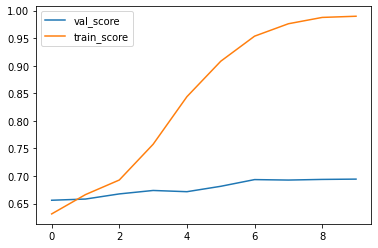

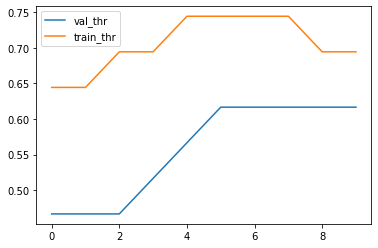

In [15]:
plot_hist(thr_score_hist)

### Train test resnet50

In [1]:
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from clip_.train import *
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [26]:
# creating dataloaders
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'
bs = 32

tr_dl = create_dl(train_df, small_images_dir_train, batch_size=bs)
tr_test_dl = create_dl(train_df, small_images_dir_val, shuffle=False, batch_size=bs)
val_dl = create_dl(val_df, small_images_dir_val, shuffle=False, batch_size=bs)
#full_dl = create_dl(df, small_images_dir, shuffle=False)

In [27]:
class CLIPImg(torch.nn.Module) :
    def __init__(self, model_name="RN50", device='cuda') :
        super().__init__()
        self.model = clip.load(model_name, device=device, jit=False)[0]
    def forward(self, imgs) :
        return self.model.encode_image(imgs)

In [28]:
model = CLIPImg()
train_tfms, val_tfms = get_tfms(crop=224)

centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
torch.save(centers, 'data/clip/centers_im_0.3_res50.pth')

In [6]:
centers = torch.load('data/clip/centers_im_0.3_res50.pth')

In [7]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers, half=True).to(device)

Using center as wieghts


In [8]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=10)

for n, _ in model.named_parameters() :
    print(n)

In [9]:
mnp = list(model.named_parameters())

param_groups = [{'params' : [p for n,p in mnp if 'embeddings' in n]}]

params_names = []
n_blocks = 5
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'layer{i}.' in n]
    ith_block_name = [n for n, p in mnp if f'layer{i}.' in n]
    params_names += ith_block_name
    param_groups.append({'params' : ith_block})
    
param_groups.append({'params' : [p for n,p in mnp if 'attnpool'in n]})
params_names += [n for n,p in mnp if 'attnpool' in n]

param_groups.append({'params' : metric_fc.parameters()})


for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

In [10]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(1e-5,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [11]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/clip/test_20ap_im_res50'

In [12]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, half_precision=True)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_0.pth


Saved best model ep 0 with f score : 0.5923946402416435
Ep 0: Train loss 14.7105 | Val f score 0.5924 with thresh 0.29, train f score 0.4926 with thresh 0.56


Saved best model ep 1 with f score : 0.6219290318389071
Ep 1: Train loss 13.0619 | Val f score 0.6219 with thresh 0.34, train f score 0.4755 with thresh 0.56


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_2.pth


Saved best model ep 2 with f score : 0.6336896602294358
Ep 2: Train loss 11.6626 | Val f score 0.6337 with thresh 0.44, train f score 0.5413 with thresh 0.66


Saved best model ep 3 with f score : 0.6588727139419738
Ep 3: Train loss 9.4484 | Val f score 0.6589 with thresh 0.49, train f score 0.6547 with thresh 0.76


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_4.pth


Saved best model ep 4 with f score : 0.6766706201743063
Ep 4: Train loss 7.0888 | Val f score 0.6767 with thresh 0.59, train f score 0.7428 with thresh 0.76


Saved best model ep 5 with f score : 0.6884154413996265
Ep 5: Train loss 5.1298 | Val f score 0.6884 with thresh 0.59, train f score 0.8078 with thresh 0.81


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_6.pth


Saved best model ep 6 with f score : 0.6937082190002374
Ep 6: Train loss 3.3783 | Val f score 0.6937 with thresh 0.64, train f score 0.8636 with thresh 0.81


Ep 7: Train loss 2.1293 | Val f score 0.6777 with thresh 0.64, train f score 0.9101 with thresh 0.86


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_8.pth


Saved best model ep 8 with f score : 0.7024859165653851
Ep 8: Train loss 1.3773 | Val f score 0.7025 with thresh 0.69, train f score 0.9408 with thresh 0.81


Ep 9: Train loss 1.0794 | Val f score 0.7024 with thresh 0.69, train f score 0.9532 with thresh 0.86


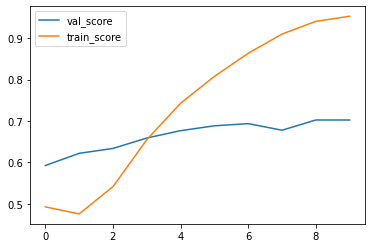

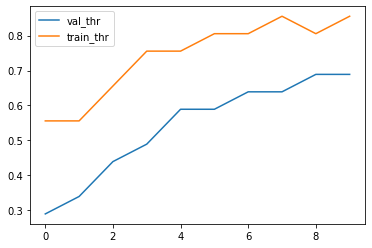

In [13]:
plot_hist(thr_score_hist)

### Effnetb0 (noclip)

In [16]:
from imports import *
from utils import load_data
from image_train.data import create_dl, ImageDS
from image_train.model import EMBRes
from arcface import ArcMarginProduct, compute_centers
from image_train.train import *
import matplotlib.pyplot as plt
np.random.seed(1337)
device = torch.device('cuda')

In [17]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [19]:
# creating dataloaders
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'
bs = 32

tr_dl = create_dl(train_df, small_images_dir_train, batch_size=bs)
tr_test_dl = create_dl(train_df, small_images_dir_val, shuffle=False, batch_size=bs)
val_dl = create_dl(val_df, small_images_dir_val, shuffle=False, batch_size=bs)
#full_dl = create_dl(df, small_images_dir, shuffle=False)

***Embeddings normalization is not done in the model but in the arcface metric***

In [22]:
vision_model = 'efficientnet_b0'
model = timm.create_model(vision_model, pretrained=True, num_classes=0).to('cuda')
train_tfms, val_tfms = get_tfms(crop=224)

In [23]:
centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
torch.save(centers, 'data/clip/centers_im_0.3_effb0.pth')

In [24]:
centers = torch.load('data/clip/centers_im_0.3_effb0.pth')

In [25]:
metric_fc = ArcMarginProduct(2048, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers).to(device)

Using center as wieghts


In [8]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=15)

for n, _ in model.named_parameters() :
    print(n)

In [27]:
mnp = list(model.named_parameters())

start = ['bn1.weight', 'bn1.bias', 'conv_stem.weight']
param_groups = [{'params' : [p for n,p in mnp if n in start]}]
params_names = [n for n,p in mnp if n in start]

n_blocks = 7
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'blocks.{i}.' in n]
    ith_block_names = [n for n, p in mnp if f'blocks.{i}.' in n] 
    param_groups.append({'params' : ith_block})
    params_names += ith_block_names
    
end = ['bn2.weight', 'bn2.bias', 'conv_head.weight']
param_groups.append({'params' : [p for n,p in mnp if n in end]})
params_names += [n for n,p in mnp if n in end]

param_groups.append({'params' : metric_fc.parameters()})


for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

In [29]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(1e-5,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [30]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/clip/test_20ap_im_effb0'

In [32]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/clip/test_20ap_im_effb0_ep_0.pth


Saved best model ep 0 with f score : 0.6848369335744343
Ep 0: Train loss 9.0092 | Val f score 0.6848 with thresh 0.91, train f score 0.6783 with thresh 1.00


Saved best model ep 1 with f score : 0.6926233519450762
Ep 1: Train loss 7.2866 | Val f score 0.6926 with thresh 0.91, train f score 0.7174 with thresh 1.05


Checkpoint : saved model to data/clip/test_20ap_im_effb0_ep_2.pth


Saved best model ep 2 with f score : 0.6998781675319034
Ep 2: Train loss 5.7266 | Val f score 0.6999 with thresh 0.96, train f score 0.7700 with thresh 1.05


Saved best model ep 3 with f score : 0.7069573718869007
Ep 3: Train loss 4.2515 | Val f score 0.7070 with thresh 0.96, train f score 0.8153 with thresh 1.10


Checkpoint : saved model to data/clip/test_20ap_im_effb0_ep_4.pth


Saved best model ep 4 with f score : 0.7090681065426806
Ep 4: Train loss 3.0850 | Val f score 0.7091 with thresh 0.96, train f score 0.8529 with thresh 1.10


Saved best model ep 5 with f score : 0.7098578800574555
Ep 5: Train loss 2.1921 | Val f score 0.7099 with thresh 0.96, train f score 0.8826 with thresh 1.10


Checkpoint : saved model to data/clip/test_20ap_im_effb0_ep_6.pth


Saved best model ep 6 with f score : 0.7105623222975299
Ep 6: Train loss 1.5107 | Val f score 0.7106 with thresh 0.96, train f score 0.9088 with thresh 1.10


Saved best model ep 7 with f score : 0.7110321206713394
Ep 7: Train loss 1.0644 | Val f score 0.7110 with thresh 0.96, train f score 0.9277 with thresh 1.10


Checkpoint : saved model to data/clip/test_20ap_im_effb0_ep_8.pth


Ep 8: Train loss 0.8136 | Val f score 0.7108 with thresh 0.96, train f score 0.9385 with thresh 1.10


Saved best model ep 9 with f score : 0.7112635714411719
Ep 9: Train loss 0.7459 | Val f score 0.7113 with thresh 0.96, train f score 0.9450 with thresh 1.10


In [9]:
for n, _ in model.named_parameters() :
    print(n)

mnp = list(model.named_parameters())

param_groups = [{'params' : [p for n,p in mnp if 'embeddings' in n]}]

params_names = []
n_blocks = 5
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'layer{i}.' in n]
    ith_block_name = [n for n, p in mnp if f'layer{i}.' in n]
    params_names += ith_block_name
    param_groups.append({'params' : ith_block})
    
param_groups.append({'params' : [p for n,p in mnp if 'attnpool'in n]})
params_names += [n for n,p in mnp if 'attnpool' in n]

param_groups.append({'params' : metric_fc.parameters()})


for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(1e-5,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/clip/test_20ap_im_res50'

best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, half_precision=True)
loss_hist.append(losses)
ep_start += n_epochsloss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/test_2ap'

In [10]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/test_2ap_ep_0.pth


Saved best model ep 0 with f score : 0.6469142561779476
Ep 0: Train loss 7.8184 | Val f score 0.6469 with thresh 0.56, train f score 0.6472 with thresh 0.73


Saved best model ep 1 with f score : 0.6575995952749828
Ep 1: Train loss 6.7015 | Val f score 0.6576 with thresh 0.61, train f score 0.7029 with thresh 0.78


KeyboardInterrupt: 

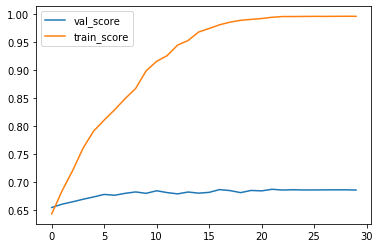

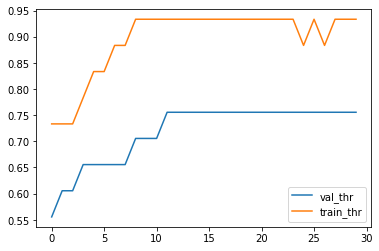

In [11]:
plot_hist(thr_score_hist)

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [26]:
# creating dataloaders
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'
bs = 32

tr_dl = create_dl(train_df, small_images_dir_train, batch_size=bs)
tr_test_dl = create_dl(train_df, small_images_dir_val, shuffle=False, batch_size=bs)
val_dl = create_dl(val_df, small_images_dir_val, shuffle=False, batch_size=bs)
#full_dl = create_dl(df, small_images_dir, shuffle=False)

In [27]:
class CLIPImg(torch.nn.Module) :
    def __init__(self, model_name="RN50", device='cuda') :
        super().__init__()
        self.model = clip.load(model_name, device=device, jit=False)[0]
    def forward(self, imgs) :
        return self.model.encode_image(imgs)

In [28]:
model = CLIPImg()
train_tfms, val_tfms = get_tfms(crop=224)

In [29]:
centers = compute_centers(tr_test_dl, model, val_tfms, train_df)
torch.save(centers, 'data/clip/centers_im_0.3_res50.pth')

TypeError: unsupported operand type(s) for /: 'JpegImageFile' and 'float'

In [6]:
centers = torch.load('data/clip/centers_im_0.3_res50.pth')

In [7]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), 
                             s=30, m=0.5, easy_margin=False, centers=centers, half=True).to(device)

Using center as wieghts


In [8]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=10)

for n, _ in model.named_parameters() :
    print(n)

In [9]:
mnp = list(model.named_parameters())

param_groups = [{'params' : [p for n,p in mnp if 'embeddings' in n]}]

params_names = []
n_blocks = 5
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'layer{i}.' in n]
    ith_block_name = [n for n, p in mnp if f'layer{i}.' in n]
    params_names += ith_block_name
    param_groups.append({'params' : ith_block})
    
param_groups.append({'params' : [p for n,p in mnp if 'attnpool'in n]})
params_names += [n for n,p in mnp if 'attnpool' in n]

param_groups.append({'params' : metric_fc.parameters()})


for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

In [10]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(1e-5,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [11]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/clip/test_20ap_im_res50'

In [12]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, train_tfms, val_tfms, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, half_precision=True)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_0.pth


Saved best model ep 0 with f score : 0.5923946402416435
Ep 0: Train loss 14.7105 | Val f score 0.5924 with thresh 0.29, train f score 0.4926 with thresh 0.56


Saved best model ep 1 with f score : 0.6219290318389071
Ep 1: Train loss 13.0619 | Val f score 0.6219 with thresh 0.34, train f score 0.4755 with thresh 0.56


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_2.pth


Saved best model ep 2 with f score : 0.6336896602294358
Ep 2: Train loss 11.6626 | Val f score 0.6337 with thresh 0.44, train f score 0.5413 with thresh 0.66


Saved best model ep 3 with f score : 0.6588727139419738
Ep 3: Train loss 9.4484 | Val f score 0.6589 with thresh 0.49, train f score 0.6547 with thresh 0.76


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_4.pth


Saved best model ep 4 with f score : 0.6766706201743063
Ep 4: Train loss 7.0888 | Val f score 0.6767 with thresh 0.59, train f score 0.7428 with thresh 0.76


Saved best model ep 5 with f score : 0.6884154413996265
Ep 5: Train loss 5.1298 | Val f score 0.6884 with thresh 0.59, train f score 0.8078 with thresh 0.81


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_6.pth


Saved best model ep 6 with f score : 0.6937082190002374
Ep 6: Train loss 3.3783 | Val f score 0.6937 with thresh 0.64, train f score 0.8636 with thresh 0.81


Ep 7: Train loss 2.1293 | Val f score 0.6777 with thresh 0.64, train f score 0.9101 with thresh 0.86


Checkpoint : saved model to data/clip/test_20ap_im_res50_ep_8.pth


Saved best model ep 8 with f score : 0.7024859165653851
Ep 8: Train loss 1.3773 | Val f score 0.7025 with thresh 0.69, train f score 0.9408 with thresh 0.81


Ep 9: Train loss 1.0794 | Val f score 0.7024 with thresh 0.69, train f score 0.9532 with thresh 0.86


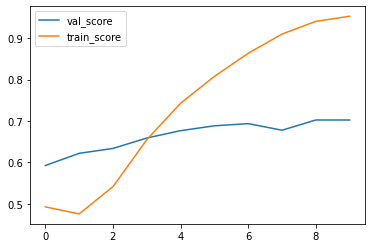

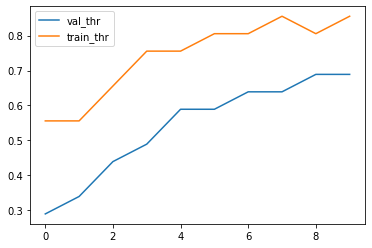

In [13]:
plot_hist(thr_score_hist)

## Only text

### Traduction indonesian english

In [1]:
from imports import *

In [2]:
def text_to_device(text, device):
    return {'input_ids' : text['input_ids'].to(device),
            'attention_mask' : text['attention_mask'].to(device)}

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

tokenizer = AutoTokenizer.from_pretrained("data/translation")
txt_model = AutoModelForSeq2SeqLM.from_pretrained("data/translation")

txt_model.cuda()
txt_model.eval()

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(54796, 512, padding_idx=54795)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(54796, 512, padding_idx=54795)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
   

In [5]:
trans_texts = []
CHUNK = 16
print('translating texts')
CTS = len(df)//CHUNK
if len(df)%CHUNK!=0: CTS += 1
for i,j in tqdm(enumerate(range(CTS)), total=CTS):
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(df))
    with torch.no_grad() :
        input_ids = tokenizer(list(df.iloc[a:b].title.values), return_tensors="pt", truncation=True, padding=True, max_length=200).input_ids.cuda()
        print(input_ids.shape)
        outputs = txt_model.generate(input_ids=input_ids, num_return_sequences=1)    
        val = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    trans_texts.extend(val)

translating texts


torch.Size([16, 49])
torch.Size([16, 45])
torch.Size([16, 40])
torch.Size([16, 35])
torch.Size([16, 49])
torch.Size([16, 59])
torch.Size([16, 36])
torch.Size([16, 41])
torch.Size([16, 34])
torch.Size([16, 51])
torch.Size([16, 34])
torch.Size([16, 30])
torch.Size([16, 34])
torch.Size([16, 48])
torch.Size([16, 34])
torch.Size([16, 33])
torch.Size([16, 55])
torch.Size([16, 78])
torch.Size([16, 50])
torch.Size([16, 43])
torch.Size([16, 37])
torch.Size([16, 49])
torch.Size([16, 51])
torch.Size([16, 55])
torch.Size([16, 36])
torch.Size([16, 90])
torch.Size([16, 47])
torch.Size([16, 46])
torch.Size([16, 39])
torch.Size([16, 40])
torch.Size([16, 33])
torch.Size([16, 38])
torch.Size([16, 42])
torch.Size([16, 34])
torch.Size([16, 54])
torch.Size([16, 48])
torch.Size([16, 52])
torch.Size([16, 38])
torch.Size([16, 95])
torch.Size([16, 79])
torch.Size([16, 79])
torch.Size([16, 54])
torch.Size([16, 73])
torch.Size([16, 35])
torch.Size([16, 46])
torch.Size([16, 42])
torch.Size([16, 34])
torch.Size([1

torch.Size([16, 41])
torch.Size([16, 39])
torch.Size([16, 39])
torch.Size([16, 59])
torch.Size([16, 31])
torch.Size([16, 33])
torch.Size([16, 52])
torch.Size([16, 61])
torch.Size([16, 46])
torch.Size([16, 43])
torch.Size([16, 44])
torch.Size([16, 37])
torch.Size([16, 51])
torch.Size([16, 43])
torch.Size([16, 40])
torch.Size([16, 45])
torch.Size([16, 33])
torch.Size([16, 36])
torch.Size([16, 52])
torch.Size([16, 35])
torch.Size([16, 50])
torch.Size([16, 54])
torch.Size([16, 56])
torch.Size([16, 30])
torch.Size([16, 52])
torch.Size([16, 45])
torch.Size([16, 45])
torch.Size([16, 56])
torch.Size([16, 28])
torch.Size([16, 50])
torch.Size([16, 55])
torch.Size([16, 48])
torch.Size([16, 58])
torch.Size([16, 51])
torch.Size([16, 45])
torch.Size([16, 47])
torch.Size([16, 53])
torch.Size([16, 40])
torch.Size([16, 49])
torch.Size([16, 50])
torch.Size([16, 42])
torch.Size([16, 47])
torch.Size([16, 43])
torch.Size([16, 45])
torch.Size([16, 47])
torch.Size([16, 51])
torch.Size([16, 37])
torch.Size([1

torch.Size([16, 44])
torch.Size([16, 34])
torch.Size([16, 38])
torch.Size([16, 45])
torch.Size([16, 38])
torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16, 37])
torch.Size([16, 84])
torch.Size([16, 62])
torch.Size([16, 37])
torch.Size([16, 45])
torch.Size([16, 50])
torch.Size([16, 53])
torch.Size([16, 45])
torch.Size([16, 39])
torch.Size([16, 43])
torch.Size([16, 40])
torch.Size([16, 37])
torch.Size([16, 41])
torch.Size([16, 35])
torch.Size([16, 40])
torch.Size([16, 37])
torch.Size([16, 30])
torch.Size([16, 49])
torch.Size([16, 30])
torch.Size([16, 49])
torch.Size([16, 96])
torch.Size([16, 37])
torch.Size([16, 37])
torch.Size([16, 62])
torch.Size([16, 28])
torch.Size([16, 37])
torch.Size([16, 34])
torch.Size([16, 43])
torch.Size([16, 40])
torch.Size([16, 38])
torch.Size([16, 73])
torch.Size([16, 63])
torch.Size([16, 50])
torch.Size([16, 45])
torch.Size([16, 129])
torch.Size([16, 30])
torch.Size([16, 48])
torch.Size([16, 33])
torch.Size([16, 28])
torch.Size([16, 42])
torch.Size([

torch.Size([16, 74])
torch.Size([16, 49])
torch.Size([16, 40])
torch.Size([16, 30])
torch.Size([16, 67])
torch.Size([16, 36])
torch.Size([16, 43])
torch.Size([16, 37])
torch.Size([16, 32])
torch.Size([16, 26])
torch.Size([16, 47])
torch.Size([16, 37])
torch.Size([16, 29])
torch.Size([16, 43])
torch.Size([16, 40])
torch.Size([16, 47])
torch.Size([16, 42])
torch.Size([16, 44])
torch.Size([16, 43])
torch.Size([16, 47])
torch.Size([16, 52])
torch.Size([16, 79])
torch.Size([16, 38])
torch.Size([16, 48])
torch.Size([16, 36])
torch.Size([16, 49])
torch.Size([16, 45])
torch.Size([16, 53])
torch.Size([16, 44])
torch.Size([16, 46])
torch.Size([16, 41])
torch.Size([16, 44])
torch.Size([16, 34])
torch.Size([16, 80])
torch.Size([16, 46])
torch.Size([16, 39])
torch.Size([16, 41])
torch.Size([16, 52])
torch.Size([16, 41])
torch.Size([16, 52])
torch.Size([16, 44])
torch.Size([16, 48])
torch.Size([16, 33])
torch.Size([16, 52])
torch.Size([16, 38])
torch.Size([16, 31])
torch.Size([16, 40])
torch.Size([1

torch.Size([16, 29])
torch.Size([16, 88])
torch.Size([16, 37])
torch.Size([16, 38])
torch.Size([16, 42])
torch.Size([16, 34])
torch.Size([16, 28])
torch.Size([16, 48])
torch.Size([16, 26])
torch.Size([16, 45])
torch.Size([16, 35])
torch.Size([16, 48])
torch.Size([16, 35])
torch.Size([16, 40])
torch.Size([16, 27])
torch.Size([16, 48])
torch.Size([16, 54])
torch.Size([16, 27])
torch.Size([16, 50])
torch.Size([16, 45])
torch.Size([16, 30])
torch.Size([16, 55])
torch.Size([16, 32])
torch.Size([16, 44])
torch.Size([16, 45])
torch.Size([16, 45])
torch.Size([16, 32])
torch.Size([16, 29])
torch.Size([16, 30])
torch.Size([16, 45])
torch.Size([16, 46])
torch.Size([16, 29])
torch.Size([16, 67])
torch.Size([16, 45])
torch.Size([16, 44])
torch.Size([16, 49])
torch.Size([16, 49])
torch.Size([16, 48])
torch.Size([16, 47])
torch.Size([16, 39])
torch.Size([16, 40])
torch.Size([16, 45])
torch.Size([16, 42])
torch.Size([16, 23])
torch.Size([16, 47])
torch.Size([16, 72])
torch.Size([16, 70])
torch.Size([1

torch.Size([16, 51])
torch.Size([16, 42])
torch.Size([16, 45])
torch.Size([16, 46])
torch.Size([16, 36])
torch.Size([16, 53])
torch.Size([16, 67])
torch.Size([16, 61])
torch.Size([16, 41])
torch.Size([16, 36])
torch.Size([16, 48])
torch.Size([16, 39])
torch.Size([16, 48])
torch.Size([16, 60])
torch.Size([16, 30])
torch.Size([16, 49])
torch.Size([16, 44])
torch.Size([16, 72])
torch.Size([16, 50])
torch.Size([16, 42])
torch.Size([16, 112])
torch.Size([16, 33])
torch.Size([16, 36])
torch.Size([16, 50])
torch.Size([16, 31])
torch.Size([16, 73])
torch.Size([16, 47])
torch.Size([16, 51])
torch.Size([16, 26])
torch.Size([16, 35])
torch.Size([16, 42])
torch.Size([16, 45])
torch.Size([16, 35])
torch.Size([16, 23])
torch.Size([16, 68])
torch.Size([16, 33])
torch.Size([16, 45])
torch.Size([16, 25])
torch.Size([16, 54])
torch.Size([16, 47])
torch.Size([16, 39])
torch.Size([16, 34])
torch.Size([16, 47])
torch.Size([16, 31])
torch.Size([16, 29])
torch.Size([16, 33])
torch.Size([16, 73])
torch.Size([

In [6]:
df['translated_titles'] = trans_texts

In [9]:
df.to_csv('data/train.csv')

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import TextDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

### Split

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
bs = 32
bs_val = 128
max_length=200

tr_ds = TextDS(train_df, max_length=max_length)
val_ds = TextDS(val_df, max_length=max_length)
full_ds = TextDS(df, max_length=max_length)

torch.save(tr_ds, 'data/text_models/datasets/clip/tr_ds_0.3_{}.pth'.format(max_length))
torch.save(val_ds, 'data/text_models/datasets/clip/val_ds_0.3_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/clip/full_ds_0.3_{}.pth'.format(max_length))

In [4]:
tr_ds = torch.load('data/text_models/datasets/clip/tr_ds_0.3_{}.pth'.format(max_length))
val_ds = torch.load('data/text_models/datasets/clip/val_ds_0.3_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/clip/full_ds_0.3_{}.pth'.format(max_length))

In [5]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [6]:
class CLIPTxt(torch.nn.Module) :
    def __init__(self, model_name="RN50", device='cuda') :
        super().__init__()
        self.model = clip.load(model_name, device=device, jit=False)[0]
    def forward(self, imgs) :
        return self.model.encode_text(imgs)

In [7]:
# model
model = CLIPTxt().to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/clip/centers_0.3_{}.pth'.format(max_length))

In [8]:
centers = torch.load('data/text_models/clip/centers_0.3_{}.pth'.format(max_length))

In [9]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [10]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=10)

In [11]:
for n, p in model.named_parameters() :
    print(n)

model.positional_embedding
model.text_projection
model.logit_scale
model.visual.conv1.weight
model.visual.bn1.weight
model.visual.bn1.bias
model.visual.conv2.weight
model.visual.bn2.weight
model.visual.bn2.bias
model.visual.conv3.weight
model.visual.bn3.weight
model.visual.bn3.bias
model.visual.layer1.0.conv1.weight
model.visual.layer1.0.bn1.weight
model.visual.layer1.0.bn1.bias
model.visual.layer1.0.conv2.weight
model.visual.layer1.0.bn2.weight
model.visual.layer1.0.bn2.bias
model.visual.layer1.0.conv3.weight
model.visual.layer1.0.bn3.weight
model.visual.layer1.0.bn3.bias
model.visual.layer1.0.downsample.0.weight
model.visual.layer1.0.downsample.1.weight
model.visual.layer1.0.downsample.1.bias
model.visual.layer1.1.conv1.weight
model.visual.layer1.1.bn1.weight
model.visual.layer1.1.bn1.bias
model.visual.layer1.1.conv2.weight
model.visual.layer1.1.bn2.weight
model.visual.layer1.1.bn2.bias
model.visual.layer1.1.conv3.weight
model.visual.layer1.1.bn3.weight
model.visual.layer1.1.bn3.bias

In [12]:
mnp = list(model.named_parameters())

param_groups = [{'params' : [p for n,p in mnp if n in ['model.token_embedding.weight', 'model.positional_embedding']]}]

params_names = [n for n,p in mnp if n in ['model.token_embedding.weight', 'model.positional_embedding']]
#print(params_names)
n_blocks = 11
for i in range(n_blocks):
    print(f'transformer.resblocks.{i}')
    ith_block = [p for n, p in mnp if f'transformer.resblocks.{i}.' in n]
    ith_block_name = [n for n, p in mnp if f'transformer.resblocks.{i}.' in n]
    params_names += ith_block_name
    #for n in params_names :
    #    print(n)
    param_groups.append({'params' : ith_block})

end = ['logit_scale', 'text_projection', 'final']
param_groups.append({'params' : [p for n,p in mnp if any(end_n in n for end_n in end)]})
params_names += [n for n,p in mnp if any(end_n in n for end_n in end)]

param_groups.append({'params' : metric_fc.parameters()})


transformer.resblocks.0
transformer.resblocks.1
transformer.resblocks.2
transformer.resblocks.3
transformer.resblocks.4
transformer.resblocks.5
transformer.resblocks.6
transformer.resblocks.7
transformer.resblocks.8
transformer.resblocks.9
transformer.resblocks.10


In [13]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(5e-6,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [14]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/clip/test_21ap_epochs'

In [15]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.6049245574192079
Ep 0: Train loss 6.6701 | Val f score 0.6049 with thresh 0.64, train f score 0.6513 with thresh 0.73


Saved best model ep 1 with f score : 0.6132073974722503
Ep 1: Train loss 6.6702 | Val f score 0.6132 with thresh 0.59, train f score 0.7104 with thresh 0.78


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_2.pth


Saved best model ep 2 with f score : 0.6279998728346883
Ep 2: Train loss 6.2191 | Val f score 0.6280 with thresh 0.69, train f score 0.7666 with thresh 0.88


Saved best model ep 3 with f score : 0.6333510523520166
Ep 3: Train loss 4.4237 | Val f score 0.6334 with thresh 0.74, train f score 0.8473 with thresh 0.93


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_4.pth


Saved best model ep 4 with f score : 0.6372354247870237
Ep 4: Train loss 2.3912 | Val f score 0.6372 with thresh 0.74, train f score 0.9145 with thresh 0.93


Saved best model ep 5 with f score : 0.6447560419127103
Ep 5: Train loss 1.0041 | Val f score 0.6448 with thresh 0.79, train f score 0.9624 with thresh 0.93


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_6.pth


Saved best model ep 6 with f score : 0.6449589980744057
Ep 6: Train loss 0.3737 | Val f score 0.6450 with thresh 0.79, train f score 0.9822 with thresh 0.88


Saved best model ep 7 with f score : 0.6450074193692245
Ep 7: Train loss 0.1815 | Val f score 0.6450 with thresh 0.79, train f score 0.9877 with thresh 0.83


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_8.pth


Ep 8: Train loss 0.1411 | Val f score 0.6444 with thresh 0.79, train f score 0.9890 with thresh 0.78


Ep 9: Train loss 0.1267 | Val f score 0.6445 with thresh 0.79, train f score 0.9896 with thresh 0.78


### Split no translation

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import TextDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [4]:
bs = 32
bs_val = 128
max_length=300

In [12]:
tr_ds = TextDS(train_df, column='title')
val_ds = TextDS(val_df, column='title')
full_ds = TextDS(df, column='title')

In [13]:
torch.save(tr_ds, 'data/text_models/datasets/clip/tr_ds_0.3_{}_no_trans.pth'.format(max_length))
torch.save(val_ds, 'data/text_models/datasets/clip/val_ds_0.3_{}_no_trans.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/clip/full_ds_0.3_{}_no_trans.pth'.format(max_length))

In [14]:
tr_ds = torch.load('data/text_models/datasets/clip/tr_ds_0.3_{}_no_trans.pth'.format(max_length))
val_ds = torch.load('data/text_models/datasets/clip/val_ds_0.3_{}_no_trans.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/clip/full_ds_0.3_{}_no_trans.pth'.format(max_length))

In [15]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [16]:
class CLIPTxt(torch.nn.Module) :
    def __init__(self, model_name="RN50", device='cuda') :
        super().__init__()
        self.model = clip.load(model_name, device=device, jit=False)[0]
    def forward(self, imgs) :
        return self.model.encode_text(imgs)

In [17]:
# model
model = CLIPTxt().to(device)

In [18]:
centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/clip/centers_0.3_{}_no_trans.pth'.format(max_length))

In [20]:
centers = torch.load('data/text_models/clip/centers_0.3_{}_no_trans.pth'.format(max_length))

In [21]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [22]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=10)

In [23]:
for n, p in model.named_parameters() :
    print(n)

model.positional_embedding
model.text_projection
model.logit_scale
model.visual.conv1.weight
model.visual.bn1.weight
model.visual.bn1.bias
model.visual.conv2.weight
model.visual.bn2.weight
model.visual.bn2.bias
model.visual.conv3.weight
model.visual.bn3.weight
model.visual.bn3.bias
model.visual.layer1.0.conv1.weight
model.visual.layer1.0.bn1.weight
model.visual.layer1.0.bn1.bias
model.visual.layer1.0.conv2.weight
model.visual.layer1.0.bn2.weight
model.visual.layer1.0.bn2.bias
model.visual.layer1.0.conv3.weight
model.visual.layer1.0.bn3.weight
model.visual.layer1.0.bn3.bias
model.visual.layer1.0.downsample.0.weight
model.visual.layer1.0.downsample.1.weight
model.visual.layer1.0.downsample.1.bias
model.visual.layer1.1.conv1.weight
model.visual.layer1.1.bn1.weight
model.visual.layer1.1.bn1.bias
model.visual.layer1.1.conv2.weight
model.visual.layer1.1.bn2.weight
model.visual.layer1.1.bn2.bias
model.visual.layer1.1.conv3.weight
model.visual.layer1.1.bn3.weight
model.visual.layer1.1.bn3.bias

In [24]:
mnp = list(model.named_parameters())

param_groups = [{'params' : [p for n,p in mnp if n in ['model.token_embedding.weight', 'model.positional_embedding']]}]

params_names = [n for n,p in mnp if n in ['model.token_embedding.weight', 'model.positional_embedding']]
#print(params_names)
n_blocks = 11
for i in range(n_blocks):
    print(f'transformer.resblocks.{i}')
    ith_block = [p for n, p in mnp if f'transformer.resblocks.{i}.' in n]
    ith_block_name = [n for n, p in mnp if f'transformer.resblocks.{i}.' in n]
    params_names += ith_block_name
    #for n in params_names :
    #    print(n)
    param_groups.append({'params' : ith_block})

end = ['logit_scale', 'text_projection', 'final']
param_groups.append({'params' : [p for n,p in mnp if any(end_n in n for end_n in end)]})
params_names += [n for n,p in mnp if any(end_n in n for end_n in end)]

param_groups.append({'params' : metric_fc.parameters()})


transformer.resblocks.0
transformer.resblocks.1
transformer.resblocks.2
transformer.resblocks.3
transformer.resblocks.4
transformer.resblocks.5
transformer.resblocks.6
transformer.resblocks.7
transformer.resblocks.8
transformer.resblocks.9
transformer.resblocks.10


In [25]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(5e-6,5e-4,len(param_groups)))

n_epochs = 10
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [26]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/clip/test_21ap_epochs'

In [27]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.6468451045094107
Ep 0: Train loss 6.2216 | Val f score 0.6468 with thresh 0.56, train f score 0.6907 with thresh 0.64


Saved best model ep 1 with f score : 0.6520438288120098
Ep 1: Train loss 6.2863 | Val f score 0.6520 with thresh 0.56, train f score 0.7341 with thresh 0.74


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_2.pth


Saved best model ep 2 with f score : 0.6709357070379441
Ep 2: Train loss 5.7792 | Val f score 0.6709 with thresh 0.66, train f score 0.7908 with thresh 0.84


Saved best model ep 3 with f score : 0.6795619122663429
Ep 3: Train loss 4.0533 | Val f score 0.6796 with thresh 0.71, train f score 0.8647 with thresh 0.89


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_4.pth


Saved best model ep 4 with f score : 0.6832157171917493
Ep 4: Train loss 2.1878 | Val f score 0.6832 with thresh 0.71, train f score 0.9210 with thresh 0.89


Ep 5: Train loss 1.0056 | Val f score 0.6824 with thresh 0.76, train f score 0.9609 with thresh 0.89


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_6.pth


Saved best model ep 6 with f score : 0.6846521698575314
Ep 6: Train loss 0.4063 | Val f score 0.6847 with thresh 0.76, train f score 0.9816 with thresh 0.89


Saved best model ep 7 with f score : 0.6874576656477703
Ep 7: Train loss 0.1733 | Val f score 0.6875 with thresh 0.76, train f score 0.9894 with thresh 0.84


Checkpoint : saved model to data/text_models/clip/test_21ap_epochs_ep_8.pth


Ep 8: Train loss 0.1089 | Val f score 0.6869 with thresh 0.76, train f score 0.9919 with thresh 0.84


Ep 9: Train loss 0.0887 | Val f score 0.6870 with thresh 0.76, train f score 0.9931 with thresh 0.79


## Multimodal training 

### Testing zero shot 

#### Translated titles

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import MultiDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
bs = 32
bs_val = 128
max_length=200

In [4]:
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'

tr_ds = MultiDS(train_df, small_images_dir_train)
val_ds = MultiDS(val_df, small_images_dir_val)
full_ds = MultiDS(df, small_images_dir_val)

torch.save(tr_ds, 'data/clip/multimodal/datasets/tr_ds_0.3.pth')
torch.save(val_ds, 'data/clip/multimodal/datasets/val_ds_0.3.pth')
torch.save(full_ds, 'data/clip/multimodal/datasets/full_ds_0.3.pth')

In [5]:
tr_ds = torch.load('data/clip/multimodal/datasets/tr_ds_0.3.pth')
val_ds = torch.load('data/clip/multimodal/datasets/val_ds_0.3.pth')
full_ds = torch.load('data/clip/multimodal/datasets/full_ds_0.3.pth')

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
model = clip.load('ViT-B/32', device=device, jit=False)[0]
train_tfms, val_tfms = get_tfms(crop=224)

In [8]:
data_path ='data/clip/multimodal/zero_shot/'

model.eval()
embs_imgs = []
embs_txt = []
for imgs, txts, _ in tqdm(full_dl, leave=False) :
    with torch.no_grad():
        imgs = val_tfms(imgs).to(device)
        txts = txts.to(device)
        embs_imgs.append(model.encode_image(imgs))
        embs_txt.append(model.encode_text(txts))
embs_imgs = F.normalize(torch.cat(embs_imgs, 0))
embs_txt = F.normalize(torch.cat(embs_txt, 0))

torch.save(embs_imgs, data_path + 'embs_imgs')
torch.save(embs_txt, data_path + 'embs_txt')

In [9]:
embs_imgs = torch.load(data_path + 'embs_imgs')
embs_txt = torch.load(data_path + 'embs_txt')

#centers per label
labels = torch.Tensor(full_ds.label_codes.values).to(device)
print(labels.shape, labels.dtype)
label_center_img = []
label_center_txt = []
for i in tqdm(range(int(labels.max().item())), leave=False) :
    idxs = (labels == i).unsqueeze(-1)
    embs_mean_img = (idxs*embs_imgs).sum(0) / idxs.sum().item()
    embs_mean_txt = (idxs*embs_txt).sum(0) / idxs.sum().item()
    label_center_img.append(embs_mean_img)
    label_center_txt.append(embs_mean_txt)
    #if i == 1 :
    #    break
label_center_img = torch.stack(label_center_img)
label_center_txt = torch.stack(label_center_txt)

torch.save(label_center_img, data_path + 'label_center_imgs')
torch.save(label_center_txt, data_path + 'label_center_txt')

In [10]:
label_center_img = torch.load(data_path + 'label_center_imgs')
label_center_txt = torch.load(data_path + 'label_center_txt')

In [11]:
labels = torch.Tensor(full_ds.label_codes.values).to(device)

In [12]:
train_indexes = train_df.index.values
val_indexes = val_df.index.values

In [13]:
# image to text
dists = embs_imgs @ label_center_txt.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.18385401368141174
Top 5 accuray : 0.3681167960166931
Top 10 accuray : 0.4508613348007202
Top 20 accuray : 0.5346569418907166
Top 50 accuray : 0.6468613147735596


In [14]:
# text to image
dists = embs_txt @ label_center_img.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.18940146267414093
Top 5 accuray : 0.38382482528686523
Top 10 accuray : 0.4717080295085907
Top 20 accuray : 0.5606131553649902
Top 50 accuray : 0.6751241087913513


In [15]:
# image to image
dists = embs_imgs @ label_center_img.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.8256350755691528
Top 5 accuray : 0.9231241345405579
Top 10 accuray : 0.9444087743759155
Top 20 accuray : 0.9600583910942078
Top 50 accuray : 0.9758248329162598


In [16]:
# text to text
dists = embs_txt @ label_center_txt.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.7429489493370056
Top 5 accuray : 0.882861316204071
Top 10 accuray : 0.9119124412536621
Top 20 accuray : 0.9325547814369202
Top 50 accuray : 0.952496349811554


#### No translation

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import MultiDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
bs = 32
bs_val = 128
max_length=200

In [4]:
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'

tr_ds = MultiDS(train_df, small_images_dir_train, column='title')
val_ds = MultiDS(val_df, small_images_dir_val, column='title')
full_ds = MultiDS(df, small_images_dir_val, column='title')

torch.save(tr_ds, 'data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
torch.save(val_ds, 'data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
torch.save(full_ds, 'data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [5]:
tr_ds = torch.load('data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
val_ds = torch.load('data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
full_ds = torch.load('data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
model = clip.load('ViT-B/32', device=device, jit=False)[0]
train_tfms, val_tfms = get_tfms(crop=224)

In [8]:
data_path ='data/clip/multimodal/zero_shot/'

model.eval()
embs_imgs = []
embs_txt = []
for imgs, txts, _ in tqdm(full_dl, leave=False) :
    with torch.no_grad():
        imgs = val_tfms(imgs).to(device)
        txts = txts.to(device)
        embs_imgs.append(model.encode_image(imgs))
        embs_txt.append(model.encode_text(txts))
embs_imgs = F.normalize(torch.cat(embs_imgs, 0))
embs_txt = F.normalize(torch.cat(embs_txt, 0))

torch.save(embs_imgs, data_path + 'embs_imgs_notrans')
torch.save(embs_txt, data_path + 'embs_txt_notrans')

In [9]:
embs_imgs = torch.load(data_path + 'embs_imgs_notrans')
embs_txt = torch.load(data_path + 'embs_txt_notrans')

In [13]:
labels = df['label_group']

In [14]:
unique_labels = labels.unique()
labels = torch.Tensor(labels.values).to('cuda')
print('Computing label centers...')
label_center_img = []
label_center_txt = []
for label in tqdm(unique_labels, leave=False) :
    idxs = (labels == label).unsqueeze(-1)
    embs_mean_img = (idxs*embs_imgs).sum(0) / idxs.sum().item()
    embs_mean_txt = (idxs*embs_txt).sum(0) / idxs.sum().item()
    label_center_img.append(embs_mean_img)
    label_center_txt.append(embs_mean_txt)
        #if i == 1 :
        #    break
label_center_img = torch.stack(label_center_img)
label_center_txt = torch.stack(label_center_txt)

Computing label centers...


In [15]:
unique_labels

array([ 249114794, 2937985045, 2395904891, ..., 1313560418,  763032672,
         53836859])

In [12]:
#centers per label
labels = torch.Tensor(full_ds.label_codes.values).to(device)
print(labels.shape, labels.dtype)
label_center_img = []
label_center_txt = []
for i in tqdm(range(int(labels.max().item())), leave=False) :
    idxs = (labels == i).unsqueeze(-1)
    embs_mean_img = (idxs*embs_imgs).sum(0) / idxs.sum().item()
    embs_mean_txt = (idxs*embs_txt).sum(0) / idxs.sum().item()
    label_center_img.append(embs_mean_img)
    label_center_txt.append(embs_mean_txt)
    #if i == 1 :
    #    break
label_center_img = torch.stack(label_center_img)
label_center_txt = torch.stack(label_center_txt)

torch.Size([34250]) torch.float32


In [13]:
torch.save(label_center_img, data_path + 'label_center_imgs_notrans')
torch.save(label_center_txt, data_path + 'label_center_txt_notrans')

In [14]:
label_center_img = torch.load(data_path + 'label_center_imgs_notrans')
label_center_txt = torch.load(data_path + 'label_center_txt_notrans')

In [15]:
# image to text
dists = embs_imgs @ label_center_txt.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.1938978135585785
Top 5 accuray : 0.38487592339515686
Top 10 accuray : 0.4625401496887207
Top 20 accuray : 0.5428029298782349
Top 50 accuray : 0.6489050984382629


In [16]:
# text to image
dists = embs_txt @ label_center_img.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.17821897566318512
Top 5 accuray : 0.3607591390609741
Top 10 accuray : 0.44370803236961365
Top 20 accuray : 0.5277372598648071
Top 50 accuray : 0.6399416327476501


In [17]:
# image to image
dists = embs_imgs @ label_center_img.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.8254890441894531
Top 5 accuray : 0.9232116937637329
Top 10 accuray : 0.9443503618240356
Top 20 accuray : 0.9599708318710327
Top 50 accuray : 0.9758832454681396


In [18]:
# text to text
dists = embs_txt @ label_center_txt.t()
for top in [1, 5, 10, 20, 50] :
    distances, indices = torch.topk(dists, top, dim=1, largest=True)
    top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
    print('Top {} accuray : {}'.format(top, top_acc))

Top 1 accuray : 0.7583649754524231
Top 5 accuray : 0.893868625164032
Top 10 accuray : 0.9208175539970398
Top 20 accuray : 0.941518247127533
Top 50 accuray : 0.9617518186569214


### Fine tuning clip

#### Zero shot without fine tuning on split

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import MultiDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
bs = 32
bs_val = 32
max_length=200

In [4]:
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'

tr_ds = MultiDS(train_df, small_images_dir_train, column='title')
val_ds = MultiDS(val_df, small_images_dir_val, column='title')
full_ds = MultiDS(df, small_images_dir_val, column='title')

torch.save(tr_ds, 'data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
torch.save(val_ds, 'data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
torch.save(full_ds, 'data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [5]:
tr_ds = torch.load('data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
val_ds = torch.load('data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
full_ds = torch.load('data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
model = clip.load('ViT-B/32', device=device, jit=False)[0]
train_tfms, val_tfms = get_tfms(crop=224)

In [9]:
def compute_top_accs(embs_image, embs_texts, labels, tops=[1, 5, 10]) :
    print('Computing label centers...')
    label_center_img = []
    label_center_txt = []
    for label in tqdm(range(int(labels.max().item())), leave=False) :
        idxs = (labels == label).unsqueeze(-1)
        embs_mean_img = (idxs*embs_image).sum(0) / idxs.sum().item()
        embs_mean_txt = (idxs*embs_texts).sum(0) / idxs.sum().item()
        label_center_img.append(embs_mean_img)
        label_center_txt.append(embs_mean_txt)
        #if i == 1 :
        #    break
    label_center_img = torch.stack(label_center_img)
    label_center_txt = torch.stack(label_center_txt)
    
    # image text
    dists = embs_image @ label_center_txt.t()
    for top in tops :
        distances, indices = torch.topk(dists, top, dim=1, largest=True)
        top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
        print('Top {} accuray image-text : {}'.format(top, top_acc))
    
    # image text
    dists = embs_texts @ label_center_img.t()
    for top in [1, 5, 10] :
        distances, indices = torch.topk(dists, top, dim=1, largest=True)
        top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
        print('Top {} accuray text-image : {}'.format(top, top_acc))

model.eval()
embs_imgs_val = []
embs_txt_val = []
ys_val = []
for imgs, txts, labels in tqdm(val_dl, leave=False) :
    with torch.no_grad():
        ys_val.append(labels)
        imgs = val_tfms(imgs).to(device)
        txts = txts.to(device)
        embs_imgs_val.append(model.encode_image(imgs))
        embs_txt_val.append(model.encode_text(txts))
embs_imgs_val = F.normalize(torch.cat(embs_imgs_val, 0))
embs_txt_val = F.normalize(torch.cat(embs_txt_val, 0))
ys_val = torch.cat(ys_val, 0).to(device)

embs_imgs_val = F.normalize(torch.cat(embs_imgs_val, 0))
embs_txt_val = F.normalize(torch.cat(embs_txt_val, 0))

torch.save(embs_imgs_val, data_path + 'embs_imgs_val')
torch.save(embs_txt_val, data_path + 'embs_txt_val')

In [ ]:
model.eval()
embs_imgs_train = []
embs_txt_train = []
ys_val = []
for imgs, txts, labels in tqdm(val_dl, leave=False) :
    with torch.no_grad():
        ys_val.append(labels)
        imgs = val_tfms(imgs).to(device)
        txts = txts.to(device)
        embs_imgs_train.append(model.encode_image(imgs))
        embs_txt_train.append(model.encode_text(txts))
embs_imgs_train = F.normalize(torch.cat(embs_imgs, 0))
embs_txt_train = F.normalize(torch.cat(embs_txt, 0))

In [14]:
data_path ='data/clip/multimodal/zero_shot/'

In [ ]:
torch.save(embs_imgs_train, data_path + 'embs_imgs_train')
torch.save(embs_txt_train, data_path + 'embs_txt_train')

In [19]:
compute_top_accs(embs_imgs_val, embs_txt_val, ys_val)

Computing label centers...


Top 1 accuray image-text : 0.22469550371170044
Top 5 accuray image-text : 0.4235195219516754
Top 10 accuray image-text : 0.5037379264831543
Top 1 accuray text-image : 0.20869381725788116
Top 5 accuray text-image : 0.40470388531684875
Top 10 accuray text-image : 0.4875682294368744


#### Fine tuning split and monti

In [1]:
from imports import *
from clip_.train_text import *
from clip_.data import MultiDS
from utils import load_data
from arcface import ArcMarginProduct
import matplotlib.pyplot as plt
import clip
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [3]:
bs = 32
bs_val = 32
max_length=200

In [4]:
small_images_dir_train = 'data/small_train_images_250/'
small_images_dir_val = 'data/small_train_images_224/'

tr_ds = MultiDS(train_df, small_images_dir_train, column='title')
val_ds = MultiDS(val_df, small_images_dir_val, column='title')
full_ds = MultiDS(df, small_images_dir_val, column='title')

torch.save(tr_ds, 'data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
torch.save(val_ds, 'data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
torch.save(full_ds, 'data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [5]:
tr_ds = torch.load('data/clip/multimodal/datasets/tr_ds_0.3_notrans.pth')
val_ds = torch.load('data/clip/multimodal/datasets/val_ds_0.3_notrans.pth')
full_ds = torch.load('data/clip/multimodal/datasets/full_ds_0.3_notrans.pth')

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
model = clip.load('ViT-B/32', device=device, jit=False)[0]
train_tfms, val_tfms = get_tfms(crop=224)

In [8]:
data_path ='data/clip/multimodal/zero_shot/'

In [9]:
clip_loss = nn.CrossEntropyLoss()

In [11]:
def compute_top_accs(embs_image, embs_texts, labels, tops=[1, 5, 10]) :
    print('Computing label centers...')
    label_center_img = []
    label_center_txt = []
    for label in tqdm(range(int(labels.max().item())), leave=False) :
        idxs = (labels == label).unsqueeze(-1)
        embs_mean_img = (idxs*embs_image).sum(0) / idxs.sum().item()
        embs_mean_txt = (idxs*embs_texts).sum(0) / idxs.sum().item()
        label_center_img.append(embs_mean_img)
        label_center_txt.append(embs_mean_txt)
        #if i == 1 :
        #    break
    label_center_img = torch.stack(label_center_img)
    label_center_txt = torch.stack(label_center_txt)
    
    # image text
    dists = embs_image @ label_center_txt.t()
    for top in tops :
        distances, indices = torch.topk(dists, top, dim=1, largest=True)
        top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
        print('Top {} accuray image-text : {}'.format(top, top_acc))
    
    # image text
    dists = embs_texts @ label_center_img.t()
    for top in [1, 5, 10] :
        distances, indices = torch.topk(dists, top, dim=1, largest=True)
        top_acc = (indices==labels.unsqueeze(-1)).sum() /len(labels)
        print('Top {} accuray text-image : {}'.format(top, top_acc))

In [12]:
def convert_models_to_fp32_(model):
    for p in model.parameters():
        p.data = p.data.float()

def train_clip(model, optimizer, sched, train_dl, val_dl, n_epochs, train_df, val_df,
          train_transforms, val_transforms, save_path, clip_loss = nn.CrossEntropyLoss()) :
    tr_losses = []
    val_losses = []
    
    convert_models_to_fp32_(model)
    
    for ep in tqdm(range(n_epochs), leave=False):
        # TRAINING
        model.train()
        tr_loss = []
        embs_imgs = []
        embs_txt = []
        ys = []
        pbar = tqdm(train_dl, leave=False)
        for imgs, txts, labels in pbar:
            
            ys.append(labels)
            labels = labels.long().to(device)
            clip_tgt = torch.arange(0, labels.size(0)).to(device)
            
            imgs = imgs.to('cuda')
            txts = txts.to('cuda')

            optimizer.zero_grad()
            
            image_features = model.encode_image(train_transforms(imgs))
            text_features = model.encode_text(txts)
            
            logits_per_image, logits_per_text = model.forward_from_features(image_features, text_features)
            loss_clip = clip_loss(logits_per_image, clip_tgt) + clip_loss(logits_per_text, clip_tgt)
            
            loss_clip.backward()
            optimizer.step()
            sched.step()
    
            tr_loss.append(loss_clip.item())
            pbar.set_description(f"Train loss: {round(np.mean(tr_loss),3)}")
            embs_imgs.append(image_features.detach().to('cpu'))
            embs_txt.append(text_features.detach().to('cpu'))
        ys = torch.cat(ys, 0).to(device)
        embs_imgs = F.normalize(torch.cat(embs_imgs, 0).to(device))
        embs_txt = F.normalize(torch.cat(embs_txt, 0).to(device))
        compute_top_accs(embs_imgs, embs_txt, ys)

        if ep % 2 == 0:
            path =  save_path + '_ep_{}.pth'.format(ep)
            print('Checkpoint : saved model to {}'.format(path))
            torch.save(model.state_dict(
            ),path)

        # VALIDATION
        model.eval()
        ys = []
        with torch.no_grad():
            pbar = tqdm(val_dl, leave=False)
            embs_imgs = []
            embs_txt = []
            val_loss = []
            
            for imgs, txts, labels in pbar:
                ys.append(labels)
                labels = labels.long().to(device)
                clip_tgt = torch.arange(0, labels.size(0)).to(device)
                
                imgs = imgs.to('cuda')
                txts = txts.to('cuda')

                optimizer.zero_grad()

                image_features = model.encode_image(val_transforms(imgs))
                text_features = model.encode_text(txts)
                
                logits_per_image, logits_per_text = model.forward_from_features(image_features, text_features)
                loss_clip = clip_loss(logits_per_image, clip_tgt) + clip_loss(logits_per_text, clip_tgt)
                
                val_loss.append(loss_clip.item())
                pbar.set_description(f"Val loss: {round(np.mean(val_loss),3)}")
                embs_imgs.append(image_features.detach().to('cpu'))
                embs_txt.append(text_features.detach().to('cpu'))
            ys = torch.cat(ys, 0).to(device)
            embs_imgs = F.normalize(torch.cat(embs_imgs, 0).to(device))
            embs_txt = F.normalize(torch.cat(embs_txt, 0).to(device))
            compute_top_accs(embs_imgs, embs_txt, ys)

        

        tr_losses.append(tr_loss)
        val_losses.append(val_loss)
        summary = "Ep {}: Train loss {:.4f} | Val loss {:.4f}".format(
            ep, np.asarray(tr_loss).mean(), np.asarray(val_loss).mean())
        print(summary)

for n, _ in model.named_parameters() :
    print(n)

In [13]:
mnp = list(model.named_parameters())

start = ['visual.class_embedding', 'visual.positional_embedding', 'visual.conv1.weight',
        'visual.ln_pre.weight', 'visual.ln_pre.bias', 'positional_embedding', 'token_embedding.weight']
param_groups = [{'params' : [p for n,p in mnp if n in start]}]
params_names = [n for n,p in mnp if n in start]

n_blocks = 12
for i in range(n_blocks):
    ith_block = [p for n, p in mnp if f'resblocks.{i}.' in n]
    ith_block_names = [n for n, p in mnp if f'resblocks.{i}.' in n] 
    param_groups.append({'params' : ith_block})
    params_names += ith_block_names
    
end = ['visual.proj', 'visual.ln_post.weight', 'visual.ln_post.bias', 'ln_final.weight', 'ln_final.bias',
      'text_projection', 'logit_scale']
param_groups.append({'params' : [p for n,p in mnp if n in end]})
params_names += [n for n,p in mnp if n in end]


for n, p in model.named_parameters() :
    if n not in params_names :
        print(n)

In [14]:
lf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(param_groups, weight_decay = 1e-5)

lr = list(np.linspace(1e-6,1e-5,len(param_groups)))

n_epochs = 2
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=0.3,
                                            total_steps=int(n_epochs * len(tr_dl)))

In [15]:
save_path = 'data/clip/multimodal/tests_ft'

In [16]:
train_clip(model, optimizer, sched, tr_dl, val_dl, n_epochs, train_df, val_df, train_tfms, val_tfms, save_path)

Computing label centers...


Top 1 accuray image-text : 0.24262452125549316
Top 5 accuray image-text : 0.493486613035202
Top 10 accuray image-text : 0.6063218712806702
Top 1 accuray text-image : 0.2616858184337616
Top 5 accuray text-image : 0.5310344696044922
Top 10 accuray text-image : 0.6477011442184448
Checkpoint : saved model to data/clip/multimodal/tests_ft_ep_0.pth


Computing label centers...


Top 1 accuray image-text : 0.25674086809158325
Top 5 accuray image-text : 0.4854682683944702
Top 10 accuray image-text : 0.582822322845459
Top 1 accuray text-image : 0.2503570020198822
Top 5 accuray text-image : 0.4873162508010864
Top 10 accuray text-image : 0.5856782793998718
Ep 0: Train loss 1.5234 | Val loss 1.2039


Computing label centers...


Top 1 accuray image-text : 0.3558429181575775
Top 5 accuray image-text : 0.6887931227684021
Top 10 accuray image-text : 0.8054597973823547
Top 1 accuray text-image : 0.3854406177997589
Top 5 accuray text-image : 0.7205938696861267
Top 10 accuray text-image : 0.8299808502197266


Computing label centers...


Top 1 accuray image-text : 0.25808483362197876
Top 5 accuray image-text : 0.4959260821342468
Top 10 accuray image-text : 0.5918521285057068
Top 1 accuray text-image : 0.26161277294158936
Top 5 accuray text-image : 0.502981960773468
Top 10 accuray text-image : 0.6058798432350159
Ep 1: Train loss 0.5667 | Val loss 1.1582
